# Figure X.x - Retraining of a supervised 3D model with unsupervised labels
Goals : 

- Show that a 3D model retrained using the output of an unsupervised model can perform similarly than a model trained on ground truth labels.

In [16]:
import numpy as np
from tifffile import imread
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

Used GPU:  <NVIDIA GeForce RTX 4070 Ti on Platform: NVIDIA CUDA (2 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ██████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 15
- Title font size : 26
- Label font size : 18


In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [18]:
data_path = DATA_PATH / "RESULTS/SUPERVISED_PERF_FIG/INFERENCE"
fold1_path = data_path / "fold1"
fold2_path = data_path / "fold2"
fold3_path = data_path / "fold3"

def get_fold_data(fold_path):
    return [imread(f) for f in fold_path.glob("*.tif") if "label" not in f.name], [imread(f) for f in fold_path.glob("*.tif") if "label" in f.name]

images = []
GT_labels = []
for fold in [fold1_path, fold2_path, fold3_path]:
    im, GT_lab = get_fold_data(fold)
    images.append(im[0])
    GT_labels.append(GT_lab[0])

In [19]:
fold_paths = [fold1_path, fold2_path, fold3_path]

def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
swin_paths = [f / "Swin" for f in fold_paths]
segresnet_paths = [f / "SegResNet" for f in fold_paths]
#################
cellpose_paths = [f / "Cellpose" for f in fold_paths]
stardist_paths = [f / "stardist" for f in fold_paths]

swin_predictions = [get_predictions(p)[0] for p in swin_paths]
segresnet_predictions = [get_predictions(p)[0] for p in segresnet_paths]
cellpose_predictions = [get_predictions(p)[0] for p in cellpose_paths]
stardist_predictions = [get_predictions(p)[0] for p in stardist_paths]

In [20]:
swin_wnet_path = DATA_PATH / "RESULTS/UNSUPERVISED_RETRAIN/inference"
swin_wnet_predictions = [imread(str(f)) for f in swin_wnet_path.glob("*.tif")]
swin_wnet_predictions.reverse()

## Computations

Text(0.5, 1.0, 'Dice metric for different thresholds for Swin-wnet and GT')

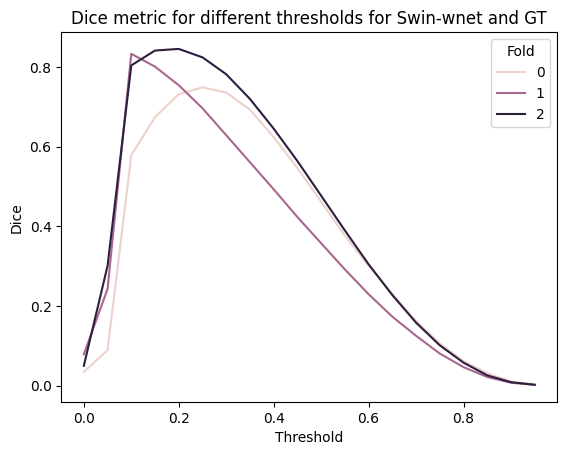

In [21]:
# plot dice metric for several thresholds for swin-wnet and GT using a dataframe that records which threshold and fold the dice was calculated for
thresh = np.arange(0, 1, 0.05)
rows = []
for t in thresh:
    for i, (gt, pred) in enumerate(zip(GT_labels, swin_wnet_predictions)):
        dices_row = {"Threshold": t, "Fold": i, "Dice": dice_coeff(
            np.where(gt > 0, 1, 0),
            np.where(pred > t, 1, 0)
            )}
        rows.append(dices_row)
        
dices_df = pd.DataFrame(rows)

sns.lineplot(data=dices_df, x="Threshold", y="Dice", hue="Fold")
plt.title("Dice metric for different thresholds for Swin-wnet and GT")

In [22]:
swin_thresholded = [np.where(swin > 0.5, swin, 0) for swin in swin_predictions]
segresnet_thresholded = [np.where(segresnet > 0.45, segresnet, 0) for segresnet in segresnet_predictions]
swin_wnet_thresholded = [np.where(wnet > 0.2, wnet, 0) for wnet in swin_wnet_predictions]

In [23]:
swin_instance = []
segresnet_instance = []
swin_wnet_instance = []

for i in range(len(fold_paths)):
    swin_instance.append(np.array(
        cle.voronoi_otsu_labeling(swin_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                         )
    segresnet_instance.append(np.array(
        cle.voronoi_otsu_labeling(segresnet_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                              )
    swin_wnet_instance.append(np.array(
        cle.voronoi_otsu_labeling(swin_wnet_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                             )

In [24]:
# from tifffile import imwrite
# for i in range(len(fold_paths)):
#     save_folder = data_path / "processed" / f"fold{i+1}"
#     save_folder.mkdir(exist_ok=True, parents=False)
#     imwrite(save_folder / "swin_instance.tif", swin_instance[i])
#     imwrite(save_folder / "segresnet_instance.tif", segresnet_instance[i])

## Plots

In [25]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [
   swin_instance,
   segresnet_instance,
#    cellpose_predictions,
#    stardist_predictions,
   swin_wnet_instance
   ]
names = ["Swin",
         "SegResNet",
        #  "Cellpose",
        #  "Stardist",
         "Swin (WNet retrained)"
         ]

model_stats = []
model_ref_name = []
fold_ref = []

for j, fold in enumerate(fold_paths):
    print("Fold ", j+1)
    for i, p in enumerate(predictions):
        print(f"Validating on {names[i]}")
        stats = [matching_dataset(
            GT_labels[j], p[j], thresh=t, show_progress=False
            ) for t in taus]
        model_stats.append(stats)
        for t in taus:
            model_ref_name.append(names[i])
            fold_ref.append(j+1)
        # uncomment for ALL plots : 
        # plot_performance(taus, stats, name=names[i])
        print("*"*20)

Fold  1
Validating on Swin
********************
Validating on SegResNet
********************
Validating on Swin (WNet retrained)
********************
Fold  2
Validating on Swin
********************
Validating on SegResNet
********************
Validating on Swin (WNet retrained)
********************
Fold  3
Validating on Swin
********************
Validating on SegResNet
********************
Validating on Swin (WNet retrained)
********************


In [26]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Model"] = model_ref_name
df["Fold"] = fold_ref
df["thresh"] = df.index
df.set_index(["Model", "Fold", "thresh"], inplace=True)
df

criterion    fp    tp    fn  precision  \
Model                 Fold thresh                                          
Swin                  1    0.1          iou   221  2793   592   0.926676   
                           0.2          iou   248  2766   619   0.917717   
                           0.3          iou   312  2702   683   0.896483   
                           0.4          iou   379  2635   750   0.874253   
                           0.5          iou   479  2535   850   0.841075   
...                                     ...   ...   ...   ...        ...   
Swin (WNet retrained) 3    0.5          iou   924  4620  2289   0.833333   
                           0.6          iou  1434  4110  2799   0.741342   
                           0.7          iou  2046  3498  3411   0.630952   
                           0.8          iou  2981  2563  4346   0.462302   
                           0.9          iou  4309  1235  5674   0.222763   

                                     recall  accuracy        f1  n_true  \
Model                 Fold thresh                                         
Swin                  1    0.1     0.825111  0.774542  0.872949    3385   
                           0.2     0.817134  0.761354  0.864510    3385   
                           0.3     0.798227  0.730863  0.844507    3385   
                           0.4     0.778434  0.700053  0.823566    3385   
                           0.5     0.748892  0.656056  0.792311    3385   
...                                     ...       ...       ...     ...   
Swin (WNet retrained) 3    0.5     0.668693  0.589812  0.741990    6909   
                           0.6     0.594876  0.492629  0.660082    6909   
                           0.7     0.506296  0.390620  0.561792    6909   
                           0.8     0.370965  0.259151  0.411628    6909   
                           0.9     0.178752  0.110091  0.198346    6909   

                                   n_pred  mean_true_score  \
Model                 Fold thresh                            
Swin                  1    0.1       3014         0.614096   
                           0.2       3014         0.613144   
                           0.3       3014         0.608406   
                           0.4       3014         0.601647   
                           0.5       3014         0.588905   
...                                   ...              ...   
Swin (WNet retrained) 3    0.5       5544         0.533343   
                           0.6       5544         0.494324   
                           0.7       5544         0.436757   
                           0.8       5544         0.335545   
                           0.9       5544         0.173046   

                                   mean_matched_score  panoptic_quality  \
Model                 Fold thresh                                         
Swin                  1    0.1               0.744259          0.649700   
                           0.2               0.750359          0.648693   
                           0.3               0.762196          0.643680   
                           0.4               0.772894          0.636529   
                           0.5               0.786368          0.623048   
...                                               ...               ...   
Swin (WNet retrained) 3    0.5               0.797589          0.591803   
                           0.6               0.830970          0.548508   
                           0.7               0.862651          0.484631   
                           0.8               0.904517          0.372324   
                           0.9               0.968076          0.192014   

                                   by_image  
Model                 Fold thresh            
Swin                  1    0.1        False  
                           0.2        False  
                           0.3        False  
                           0.4        False  
          

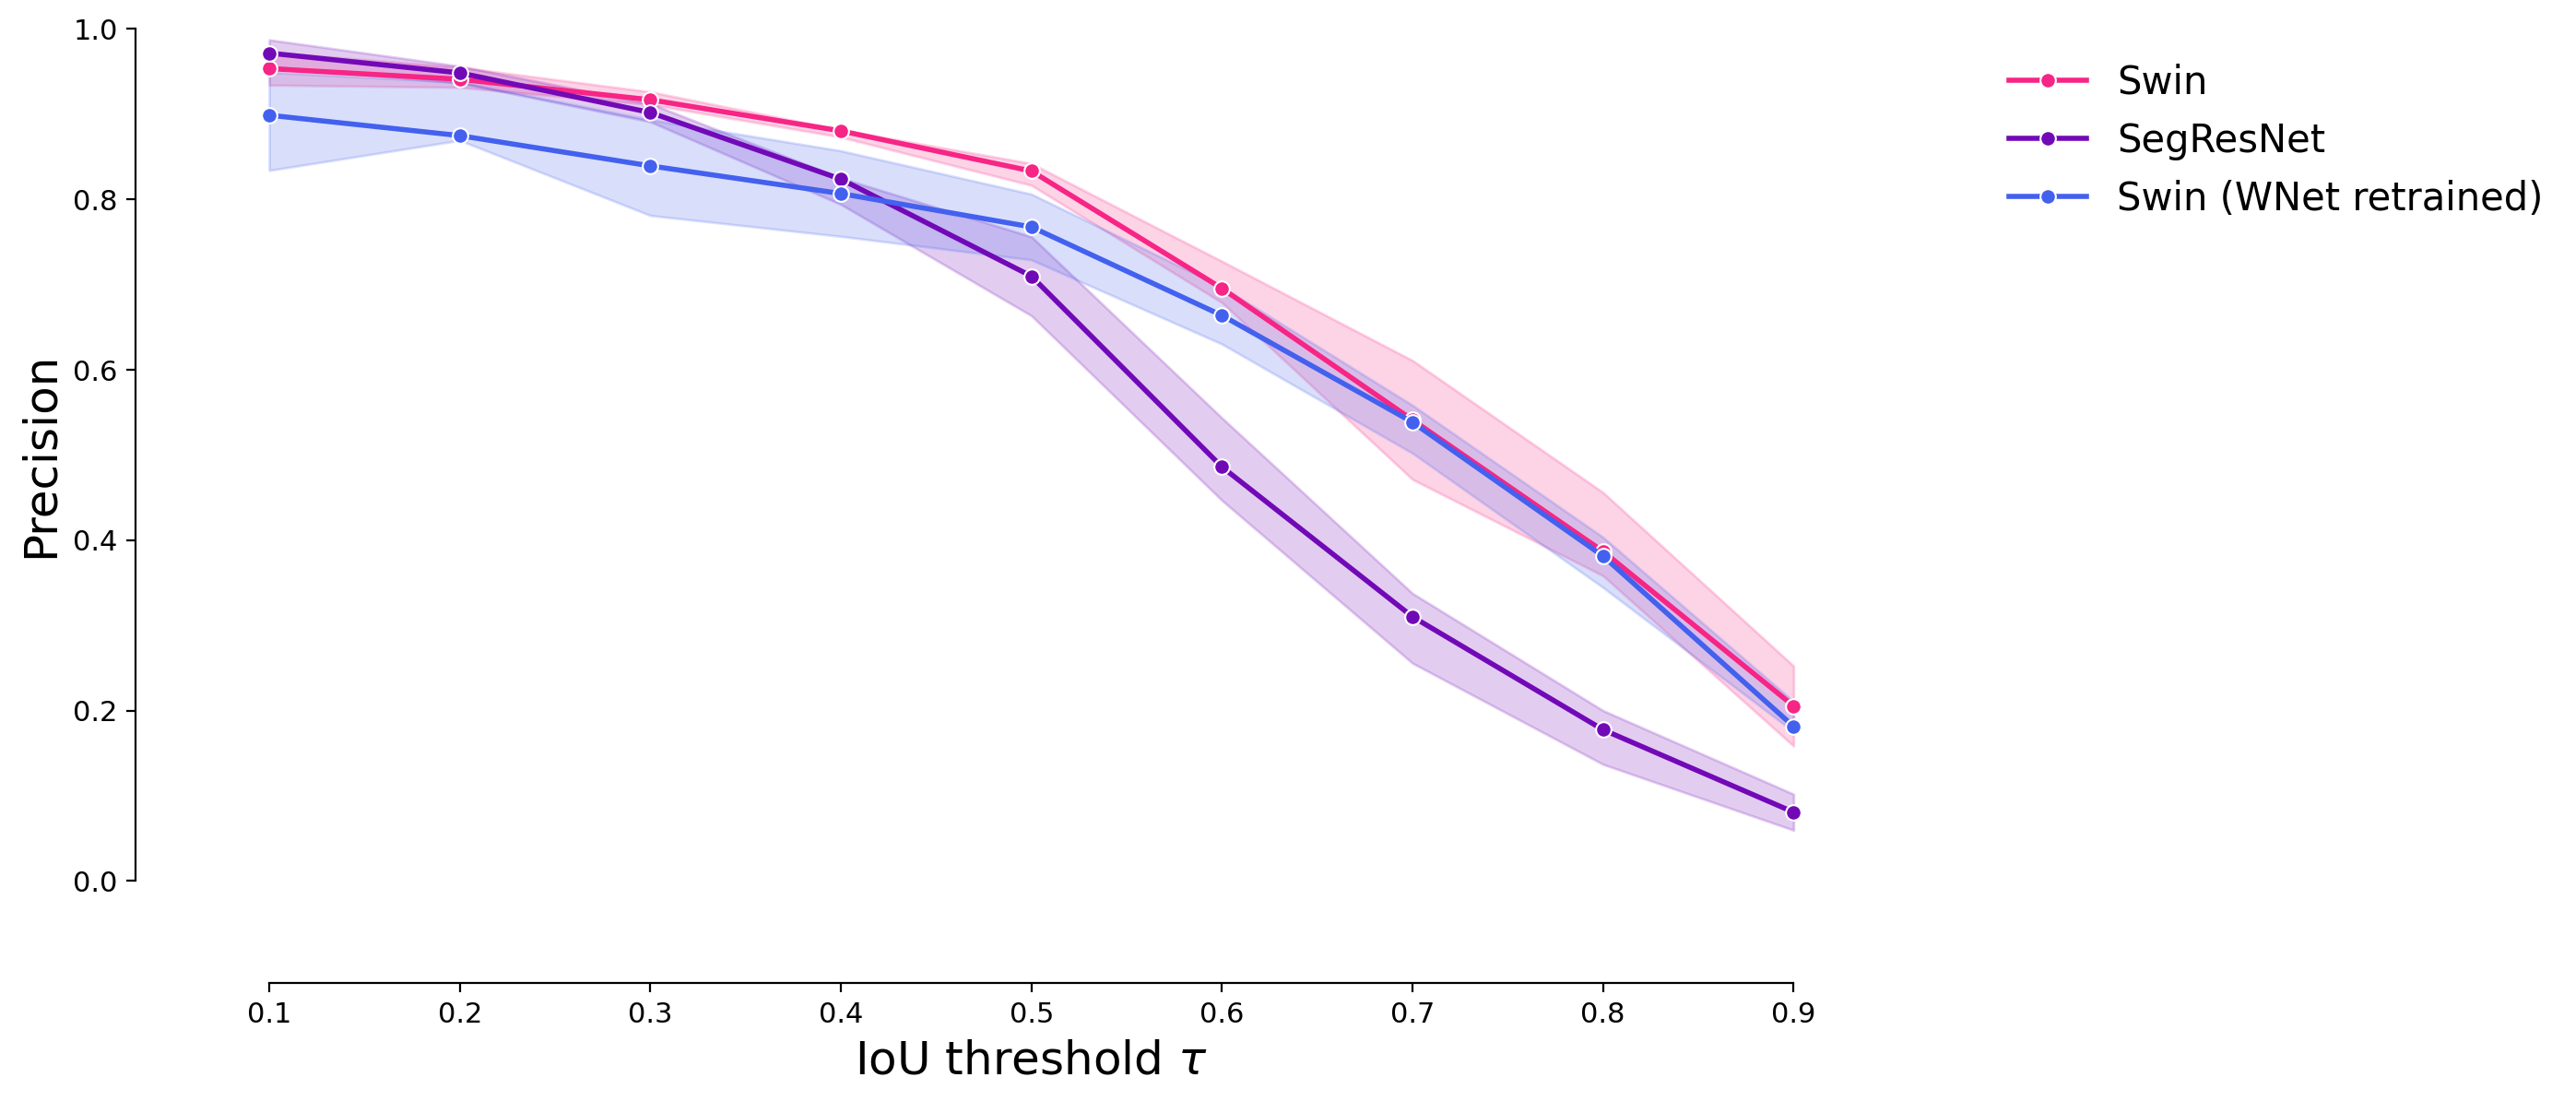

In [27]:
plot_stat_comparison_fold(df, stat="precision")
if SAVE_PLOTS_AS_PNG:
    plt.savefig( "precision_comparison.png", bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "precision_comparison.svg", bbox_inches="tight")

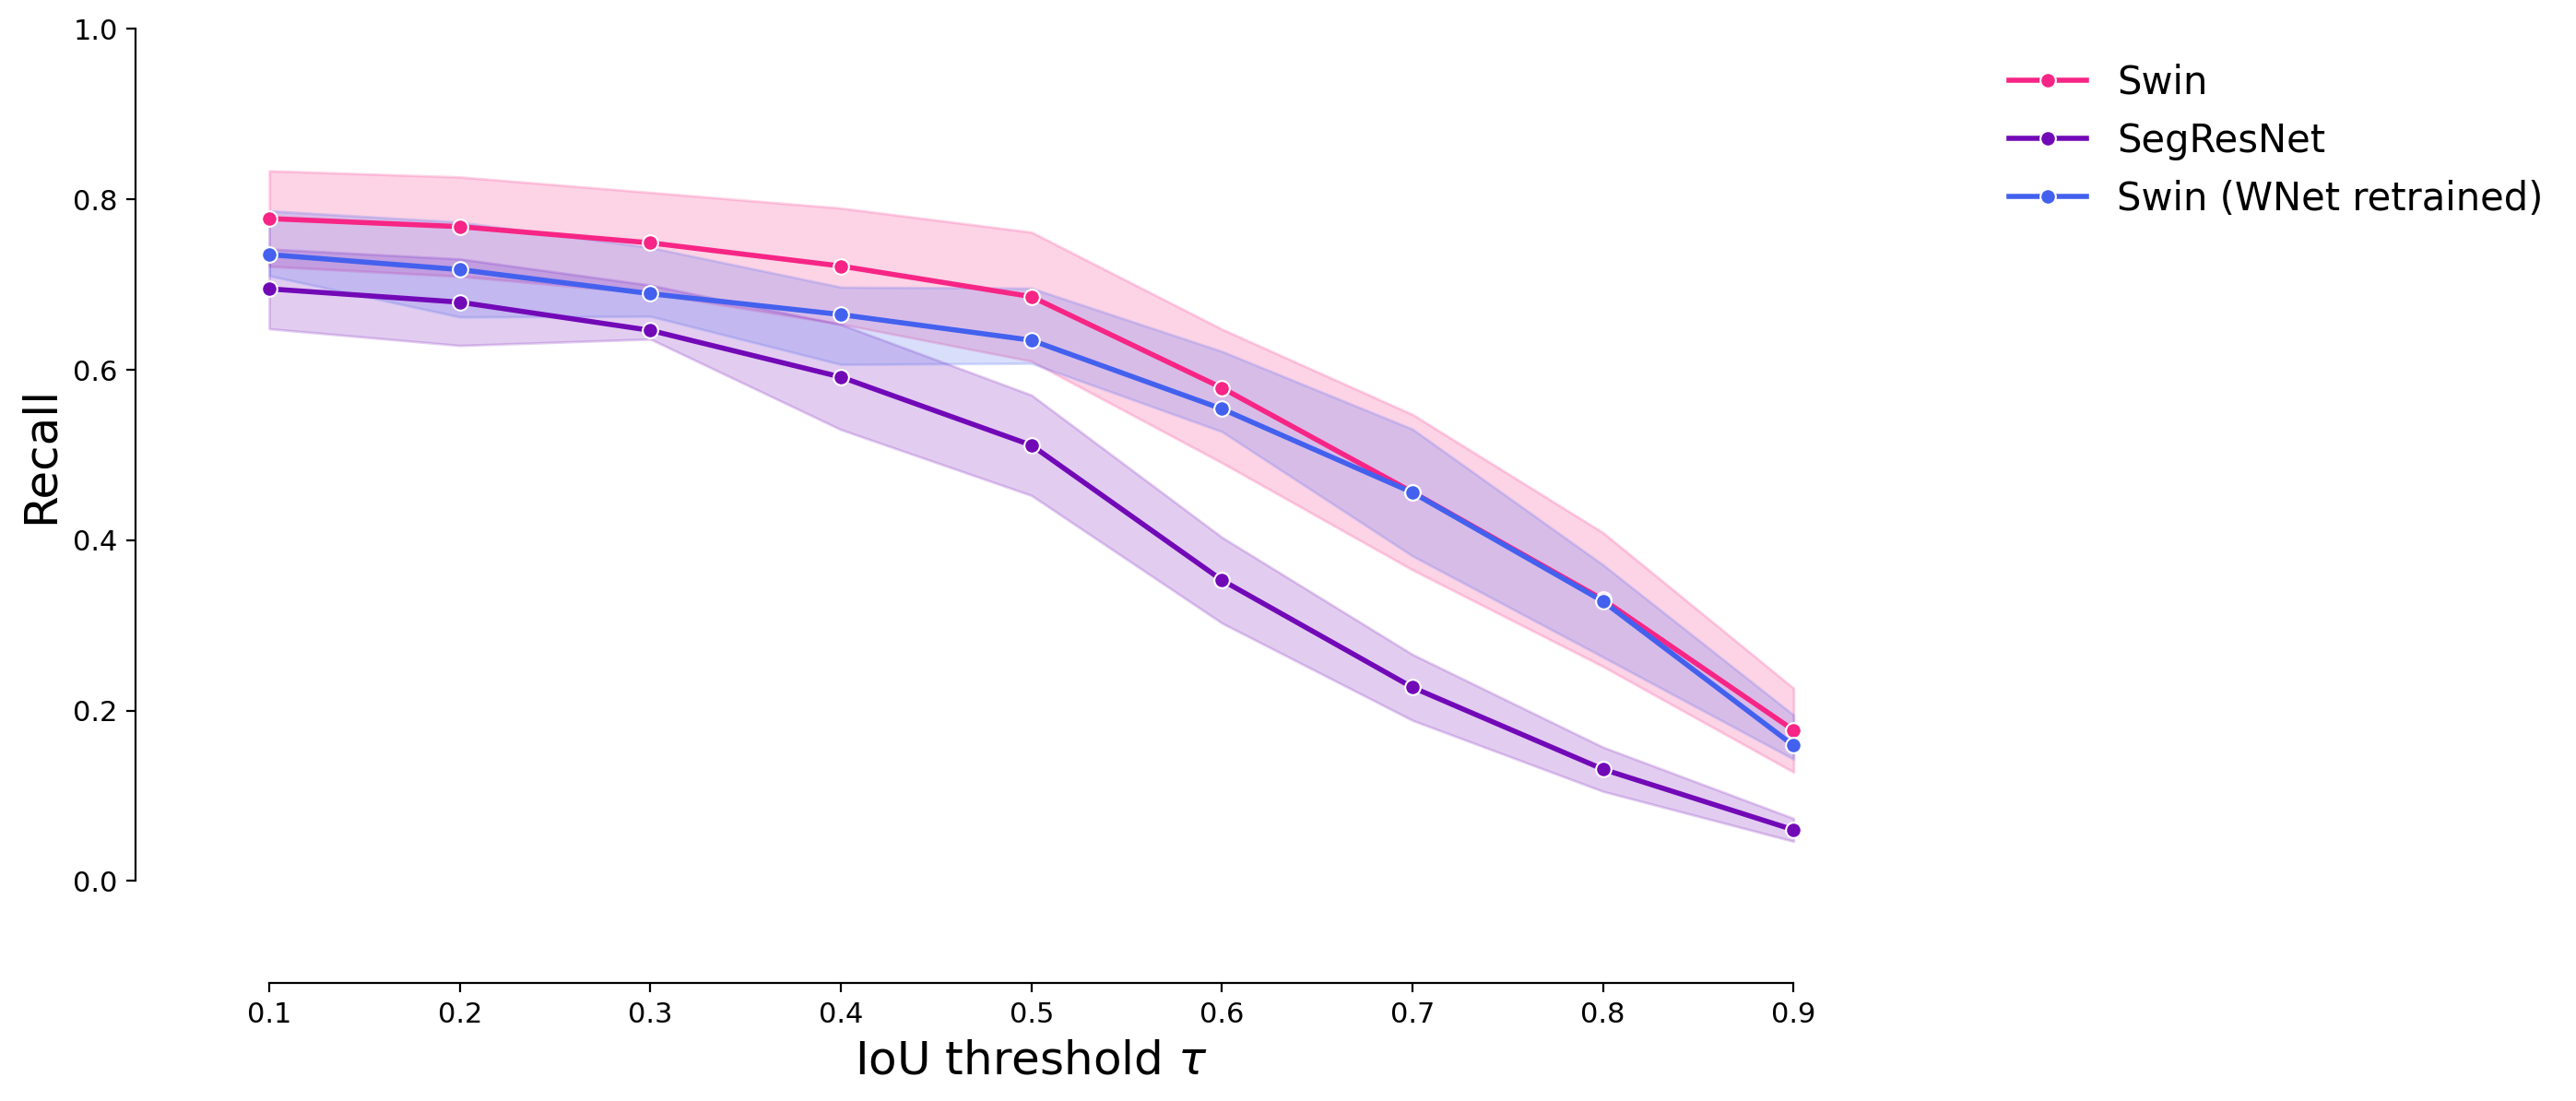

In [28]:
plot_stat_comparison_fold(df, stat="recall")
if SAVE_PLOTS_AS_PNG:
    plt.savefig( "recall_comparison.png")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "recall_comparison.svg", bbox_inches="tight")

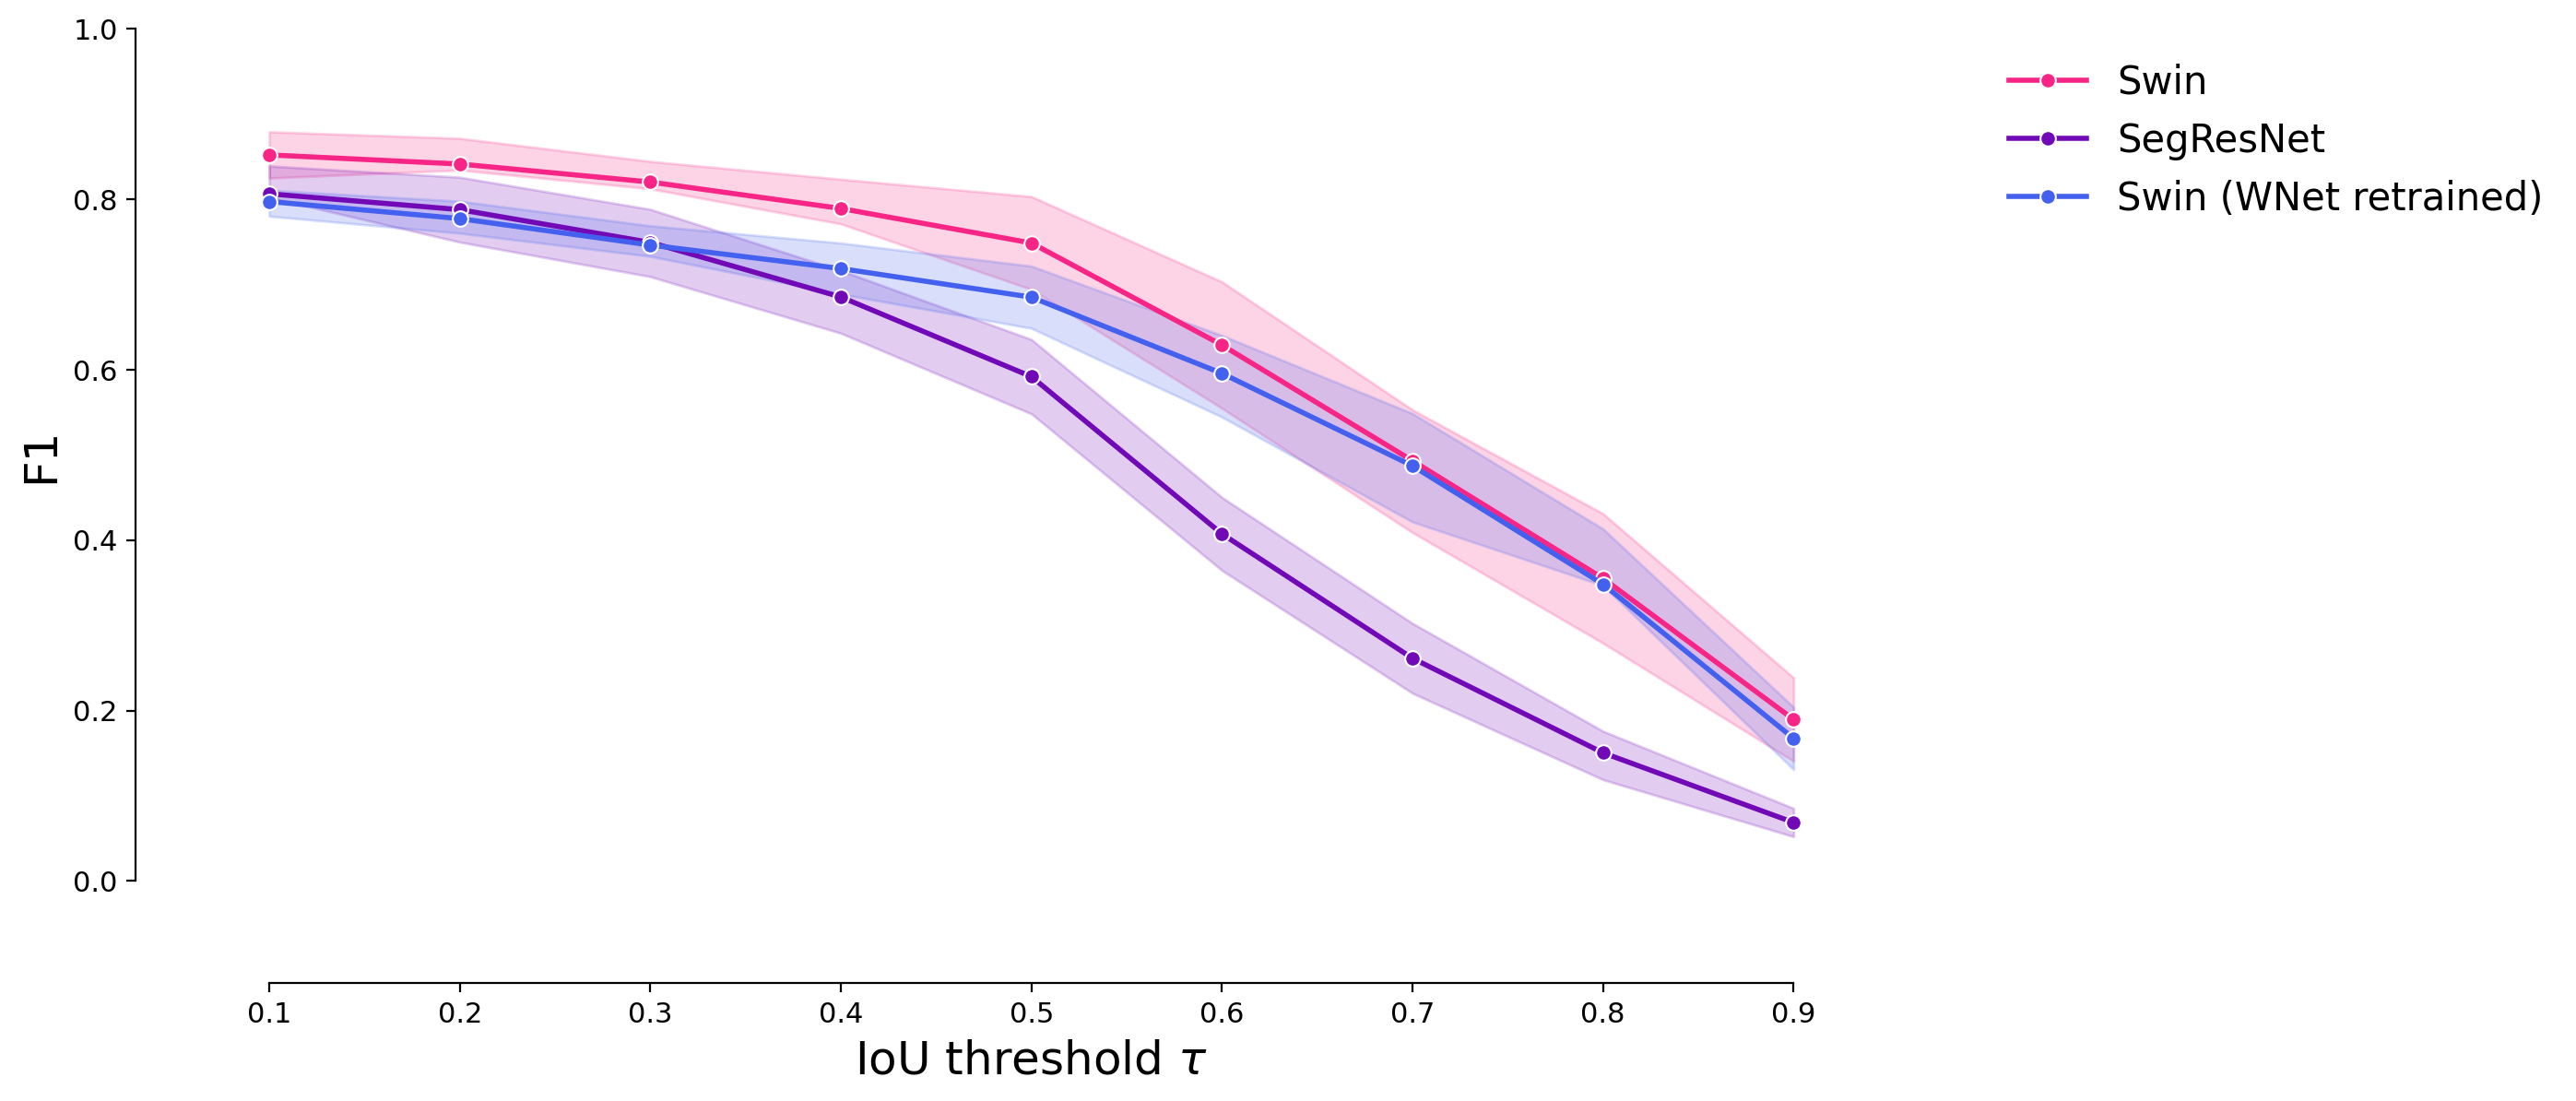

In [29]:
plot_stat_comparison_fold(df, stat="f1")
if SAVE_PLOTS_AS_PNG:
    plt.savefig( "f1_comparison.png")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "f1_comparison.svg", bbox_inches="tight")

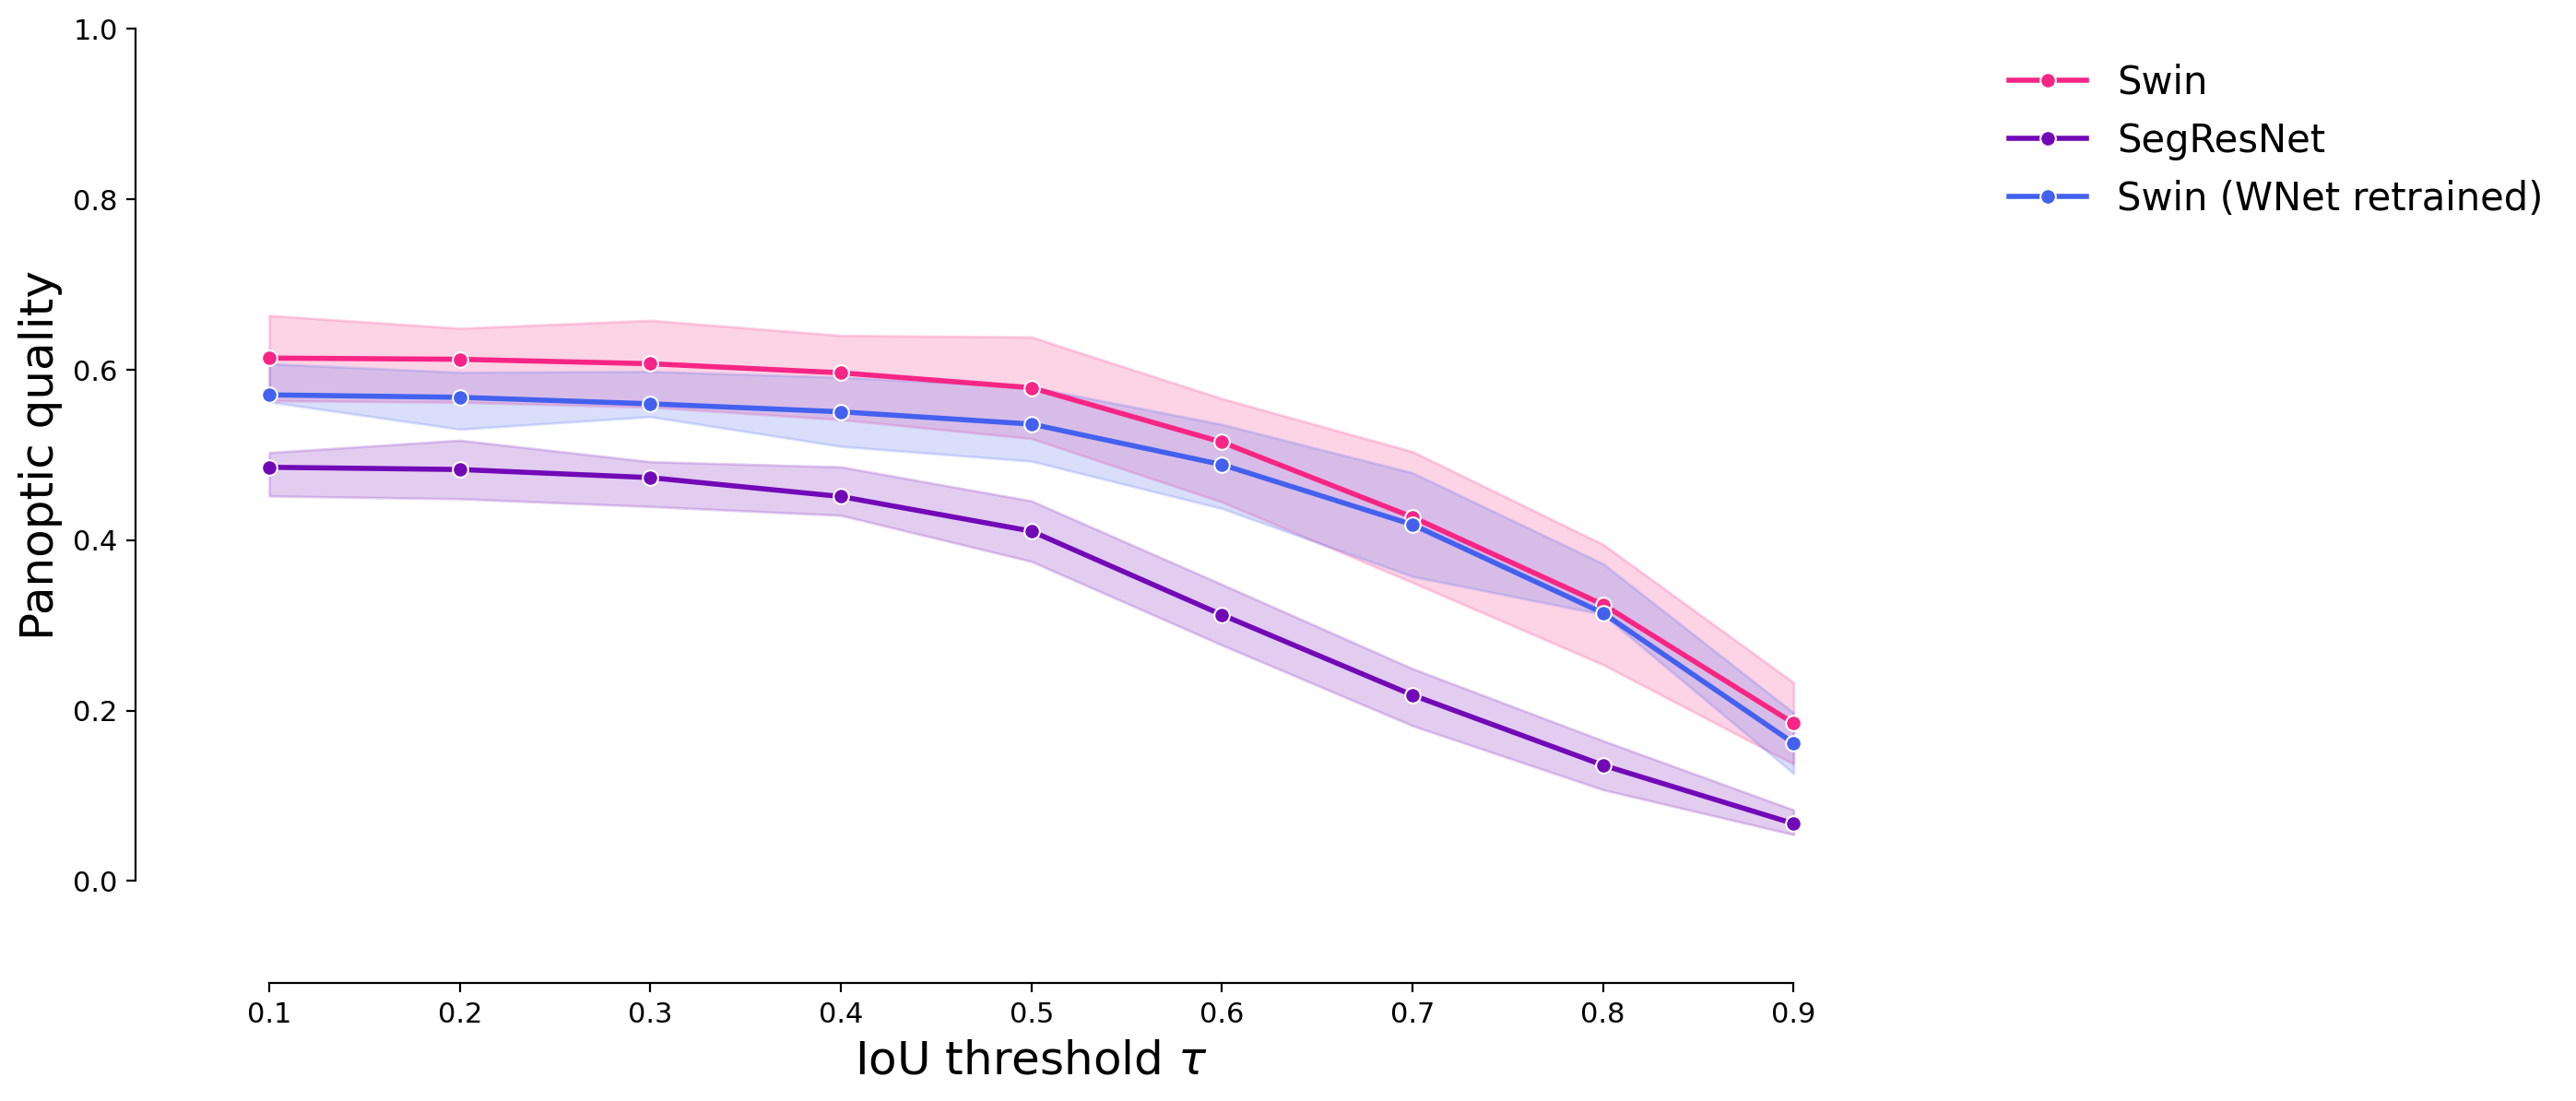

In [30]:
plot_stat_comparison_fold(df, stat="panoptic_quality")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("panoptic_quality_comparison.png")
if SAVE_PLOTS_AS_SVG:
    plt.savefig( "panoptic_quality_comparison.svg", bbox_inches="tight")